### Calculate multidimensional disentanglement metric

#### imports and functions

In [8]:
# imports
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.compat.v1 import gfile
import pdb
import pickle

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # CPU-only

sys.path.append(os.path.abspath("/home/mwu34/disentanglement_lib"))
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from sklearn import svm
import itertools

from scipy.stats import spearmanr

In [2]:
from disentanglement_lib.data.ground_truth import named_data
# manualdsprites = named_data.get_named_ground_truth_data('manual_dsprites', -1)
# dsprites = named_data.get_named_ground_truth_data('dsprites_full', -1)
# smallnorb = named_data.get_named_ground_truth_data('smallnorb', -1)
# mpi3d = named_data.get_named_ground_truth_data('mpi3d_toy', -1)
# cars3d = named_data.get_named_ground_truth_data('cars3d', -1)
shapes3d = named_data.get_named_ground_truth_data('shapes3d', -1)

In [3]:
dataset_embedding_dimensions = {
    "manual_dsprites": (1, 1, 2, 1, 1),
    "mpi3d_toy": (2, 2, 1, 1, 1, 1, 1),
    "cars3d": (1, 2, 3),
    "shapes3d": (2, 2, 2, 1, 2, 1),
}
dataset_supervised_loss = {
    "mpi3d_toy": ("multidimensional_embed", "multidimensional_embed", "xent", "xent", "xent", "xent", "xent"),
    "cars3d": ("xent", "multidimensional_embed", "multidimensional_embed"),
    "shapes3d": ("multidimensional_embed", "multidimensional_embed", "multidimensional_embed",
        "xent", "multidimensional_embed", "xent"),
}


In [52]:
def calculate_multidimensional_sap(
    dataset,
    num_training_points,
    num_testing_points,
    model_artifact_dir,
    max_latent_dims,
):
    # use same set of indices for all mig calculation
    all_indices = np.random.choice(
        len(dataset.images),
        num_training_points + num_testing_points,
        replace=False)
    factors = dataset.index_to_factors(all_indices).T

    mean_file_path = os.path.join(model_artifact_dir, f"dropout_mean_iter_1.npy")
    mus = np.load(mean_file_path)
    mus_train = mus[all_indices[:num_training_points], :].T
    mus_test = mus[all_indices[num_training_points:], :].T
    factors_train = factors[:, :num_training_points]
    factors_test = factors[:, num_training_points:]
    
    scores_each_factor = compute_sap_score(
        mus_train,
        factors_train,
        mus_test,
        factors_test,
        max_latent_dims=max_latent_dims
    )
    return scores_each_factor
    
    
def compute_sap_score(mus, ys, mus_test, ys_test, max_latent_dims=1):
    """calculates prediction scores using all possible latent unit combinations."""
    num_latents = mus.shape[0]
    num_factors = ys.shape[0]
    scores_each_factor = []
    
    for factor in range(num_factors):
        scores = []
        for dims in range(1, max_latent_dims + 1):
            latent_indices = list(itertools.combinations(list(range(num_latents)), dims))
            # print(latent_indices)
            for latent_idx in latent_indices:
                classifier = svm.LinearSVC(C=0.01, class_weight="balanced")
                classifier.fit(mus[latent_idx, :].T, ys[factor, :].T)
                pred = classifier.predict(mus_test[latent_idx, :].T)
                scores.append(np.mean(pred == ys_test[factor, :].T))
        scores_each_factor.append(scores)
    return scores_each_factor

#### calculate multidimensional SAP score

In [6]:
dataset_dict = {
    # "'mpi3d_toy'": mpi3d,
    "'shapes3d'": shapes3d,
    # "'cars3d'": cars3d,
}
sap_max_latent_dims_dict = {
    "'mpi3d_toy'": 2,
    "'shapes3d'": 2,
    "'cars3d'": 3,
}


In [73]:
num_training_points=10000
num_testing_points=5000
exp_idx = 8
study_name = 'embeddings' # 'active_learning' or 'embeddings'
results_file_name = 'embeddings' # 'semi' or embeddings
# model_folder_path = '/mnt/data1/active_learning_representations/'
model_folder_path = '/home/mwu34/disentanglement_lib/'


num_latents = 10
classifier_latent_indices = list(itertools.combinations(list(range(num_latents)), 1)) \
    + list(itertools.combinations(list(range(num_latents)), 2)) \
    + list(itertools.combinations(list(range(num_latents)), 3))

aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_{results_file_name}_v{exp_idx}.json"
df = pd.read_json(aggregated_results_path)

for idx in range(len(df)):
    model_idx = df.iloc[idx]['train_final_config.model.model_num']
    dataset_name = df.iloc[idx]['train_final_config.dataset.name']
    # if dataset_name not in dataset_dict.keys():
    #     continue
    if dataset_name != "'shapes3d'":
        continue
        
    dataset = dataset_dict[dataset_name]
    print(model_idx, dataset_name)
    model_artifact_dir=os.path.join(
        model_folder_path,
        f"output_{study_name}_study_v{exp_idx}/{model_idx}/model/artifacts/"
    )
    results_file_path = os.path.join(model_artifact_dir, "multidimensional_sap_results.npy")
    # if ~os.path.exists(results_file_path):
    #     continue
    # else:
    results = calculate_multidimensional_sap(
        dataset,
        num_training_points=10000,
        num_testing_points=5000,
        model_artifact_dir=model_artifact_dir,
        max_latent_dims=sap_max_latent_dims_dict[dataset_name]
    )
    np.save(results_file_path, np.array(results))
    print(f'calculated multiD SAP at model {model_idx}')

16 'shapes3d'


/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/miniconda3/envs/tf1.5/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/mwu34/minicond

KeyboardInterrupt: 

#### visualize loss between labelled data points and embedding values

In [62]:
def calculate_embeddings(exp_idx, model_idx, num_embeddings, axs=None, storage_path='/home/mwu34/disentanglement_lib/'):
    """plot out the visualization of each embedding value for each factor."""
    folder_path = f'{storage_path}output_embeddings_study_v{exp_idx}/'
    hub_path = os.path.join(folder_path, f"{model_idx}/model/tfhub")
    checkpoint_path = os.path.join(folder_path, f"{model_idx}/model/tf_checkpoint")
    variable_list = [var for var, shape in tf.train.list_variables(checkpoint_path)]

    # fig, axs = plt.subplots(1, num_embeddings, figsize=(18, 5))
    # by default loads the latest checkpoint
    embeddings = []
    for idx in range(num_embeddings):
        if exp_idx >= 6:
            var_name = f'{idx}/embedding'
        else:
            var_name = f'supervised_loss/{idx}/embedding'
            
        if var_name in variable_list:
            embedding = tf.train.load_variable(checkpoint_path, var_name)
            if embedding.shape[0] < embedding.shape[1]:
                embedding = embedding.T
            embeddings.append(embedding)
            if axs:
                ax = axs[idx]
                if embedding.shape[1] == 1:
                    ax.plot(embedding[:, 0])
                elif embedding.shape[1] == 2:
                    ax.scatter(embedding[:, 0], embedding[:, 1], c = range(len(embedding)), cmap='cool')
                else:
                    raise ValueError("can't show embedding with > 2 dimensions.")
    return embeddings


##### exp v3: manual dsprites (obsolete)

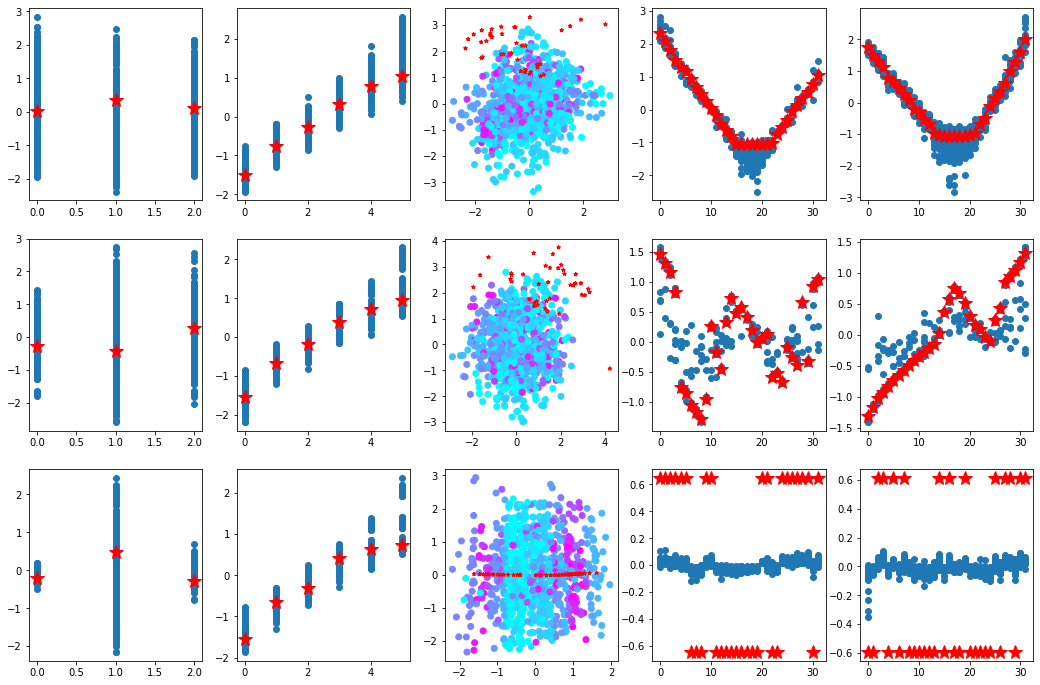

In [97]:
# works in exp 3, where all results are on the same dataset

exp_idx = 3
dataset = manualdsprites
model_indices = [15, 16, 17]
num_embeddings = 5
embedding_dimensions = [1,1,2,1,1]

fig, axs = plt.subplots(len(model_indices), num_embeddings, figsize=(18, 4*len(model_indices)))
for fig_idx, model_idx in enumerate(model_indices):
    # retrieve embeddings
    embedding = calculate_embeddings(exp_idx, model_idx, num_embeddings)
    
    # retrieve labelled points (representations and factors)
    artifact_path = f'/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/{model_idx}/model/artifacts'
    labelled_indices = np.load(os.path.join(artifact_path, 'labelled_indices_iter_0.npy'))
    representations = np.load(os.path.join(artifact_path, 'dropout_mean_iter_1.npy'))
    labelled_factors = dataset.index_to_factors(labelled_indices)
    labelled_representations = representations[labelled_indices, :]
    
    latent_idx = 0
    for emb_idx in range(num_embeddings):
        ax = axs[fig_idx, emb_idx]
        if embedding_dimensions[emb_idx] == 1:
            ax.scatter(labelled_factors[:, emb_idx], labelled_representations[:, latent_idx])
            ax.plot(list(range(len(embedding[emb_idx]))), embedding[emb_idx][:, 0], 'r*', ms=15)
            latent_idx += 1
        else:
            colors = labelled_factors[:, emb_idx] / 40
            ax.scatter(
                labelled_representations[:, latent_idx],
                labelled_representations[:, latent_idx+1],
                c = colors,
                cmap='cool'
            )
            ax.scatter(
                embedding[emb_idx][:, 0],
                embedding[emb_idx][:, 1],
                c = np.linspace(0, 1, 40),
                marker = '*',
                edgecolors = 'r',
                s = 15,
                cmap='cool'
            )
            latent_idx += 2
            
    

##### exp v4: mixed VAE on mpi3d

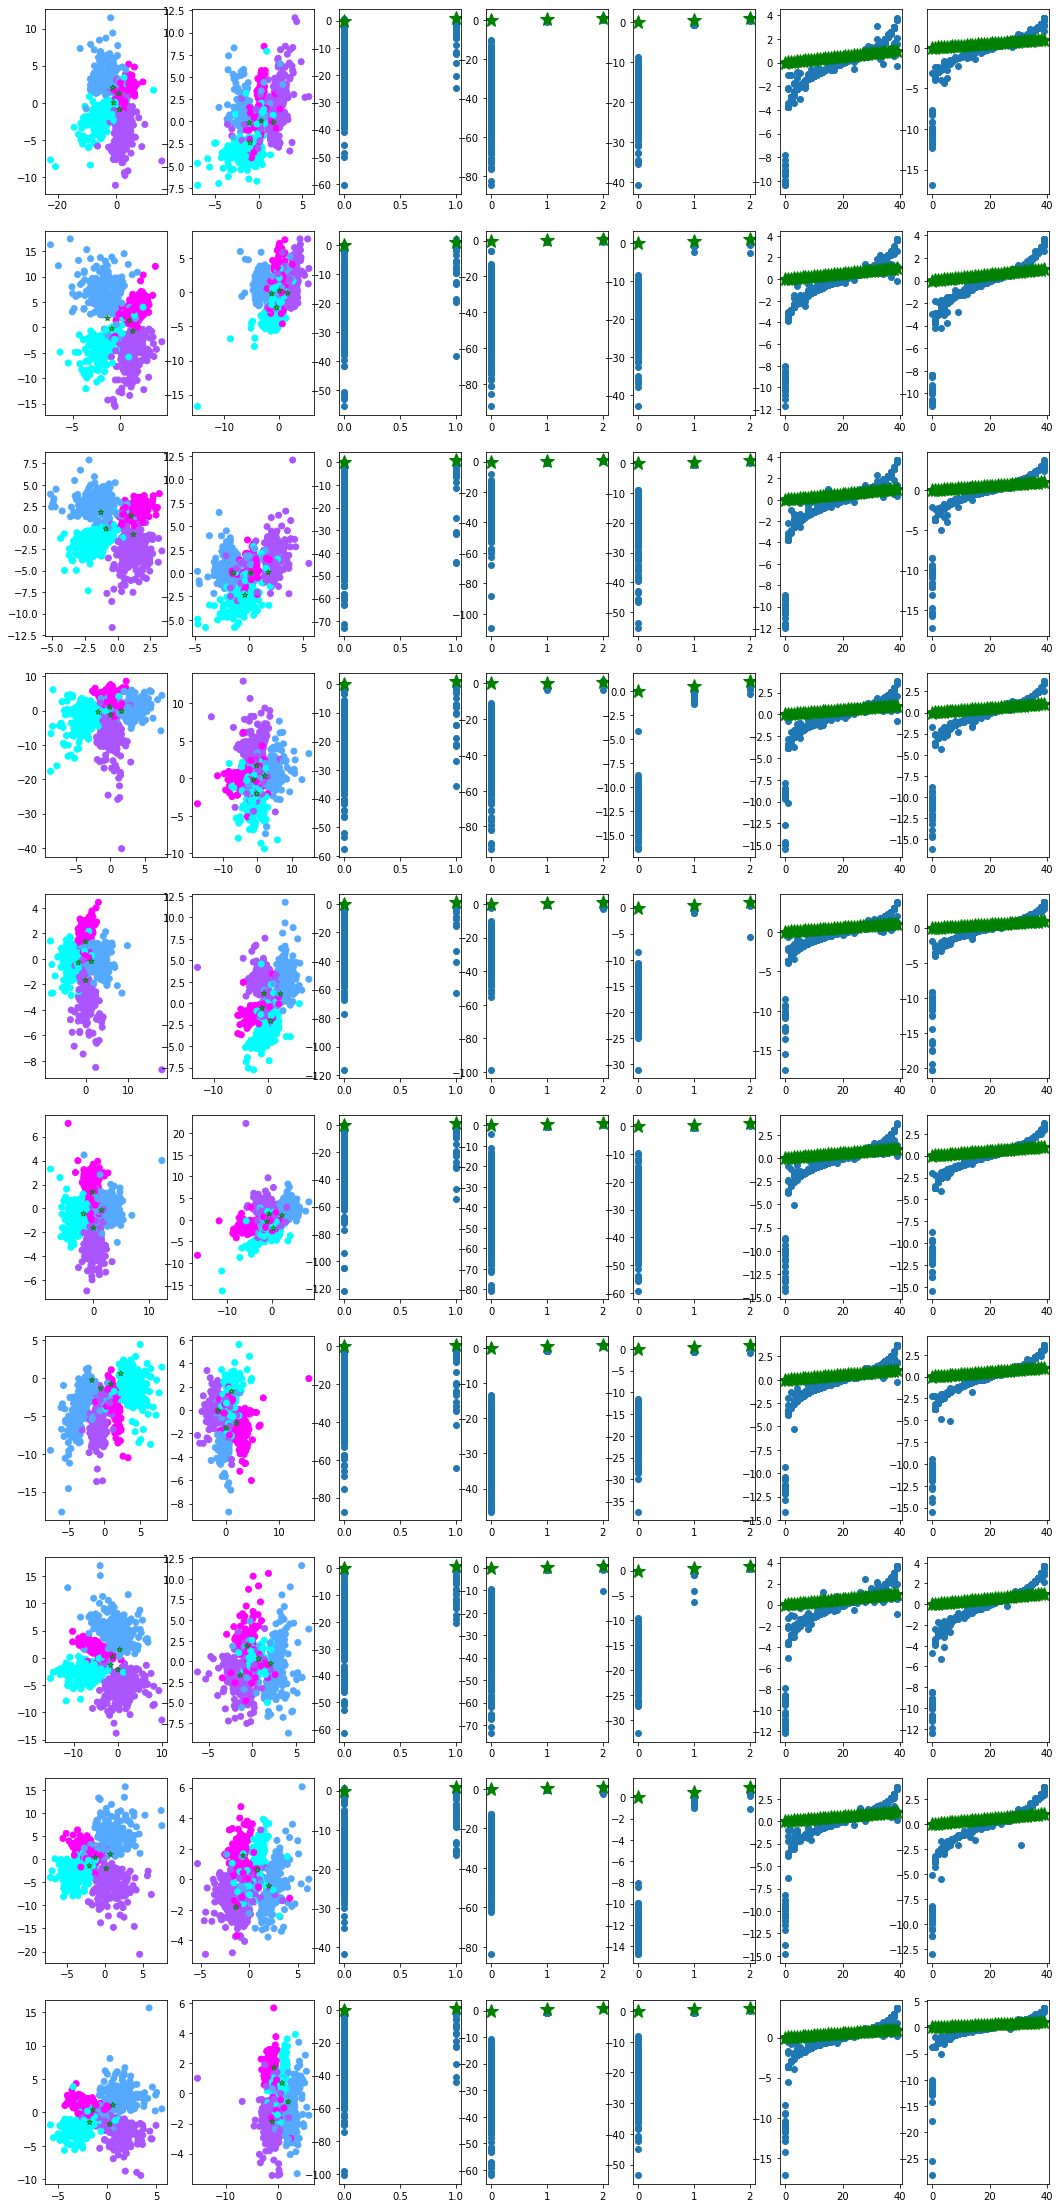

In [29]:
# works on exp v4, use model_name to find results
exp_idx = 4
dataset = mpi3d
dataset_name = 'mpi3d_toy'
dataset_name_in_df = "'mpi3d_toy'"

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_embeddings_v{exp_idx}.json"
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

fig, axs = plt.subplots(len(model_indices), num_embeddings, figsize=(18, 4*len(model_indices)))
for fig_idx, model_idx in enumerate(model_indices):
    # retrieve embeddings
    embedding = calculate_embeddings(exp_idx, model_idx, num_embeddings)
    
    # retrieve labelled points (representations and factors)
    artifact_path = f'/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/{model_idx}/model/artifacts'
    labelled_indices = np.load(os.path.join(artifact_path, 'labelled_indices_iter_0.npy'))
    representations = np.load(os.path.join(artifact_path, 'dropout_mean_iter_1.npy'))
    labelled_factors = dataset.index_to_factors(labelled_indices)
    labelled_representations = representations[labelled_indices, :]
    
    latent_idx = 0
    learned_embedding_idx = 0
    for emb_idx in range(num_embeddings):
        ax = axs[fig_idx, emb_idx]
        if loss_terms[emb_idx] == 'multidimensional_embed':
            curr_embedding = embedding[learned_embedding_idx]
            learned_embedding_idx += 1
        else:
            curr_embedding = np.expand_dims(np.linspace(0, 1, dataset.factor_sizes[emb_idx]), axis=1)
        
        if embedding_dimensions[emb_idx] == 1:
            ax.scatter(labelled_factors[:, emb_idx], labelled_representations[:, latent_idx])
            ax.plot(list(range(len(curr_embedding))), curr_embedding[:, 0], 'g*', ms=15)
            latent_idx += 1
        else:
            colors = labelled_factors[:, emb_idx] / dataset.factor_sizes[emb_idx]
            ax.scatter(
                labelled_representations[:, latent_idx],
                labelled_representations[:, latent_idx+1],
                c = colors,
                cmap='cool'
            )
            ax.scatter(
                curr_embedding[:, 0],
                curr_embedding[:, 1],
                c = np.linspace(0, 1, dataset.factor_sizes[emb_idx]),
                marker = '*',
                edgecolors = 'g',
                s = 30,
                cmap='cool'
            )
            latent_idx += 2
            
    
    

##### exp v4: mixed VAE on shapes3d

[15, 16, 17, 24, 25, 26, 33, 34, 35, 42, 43, 44]


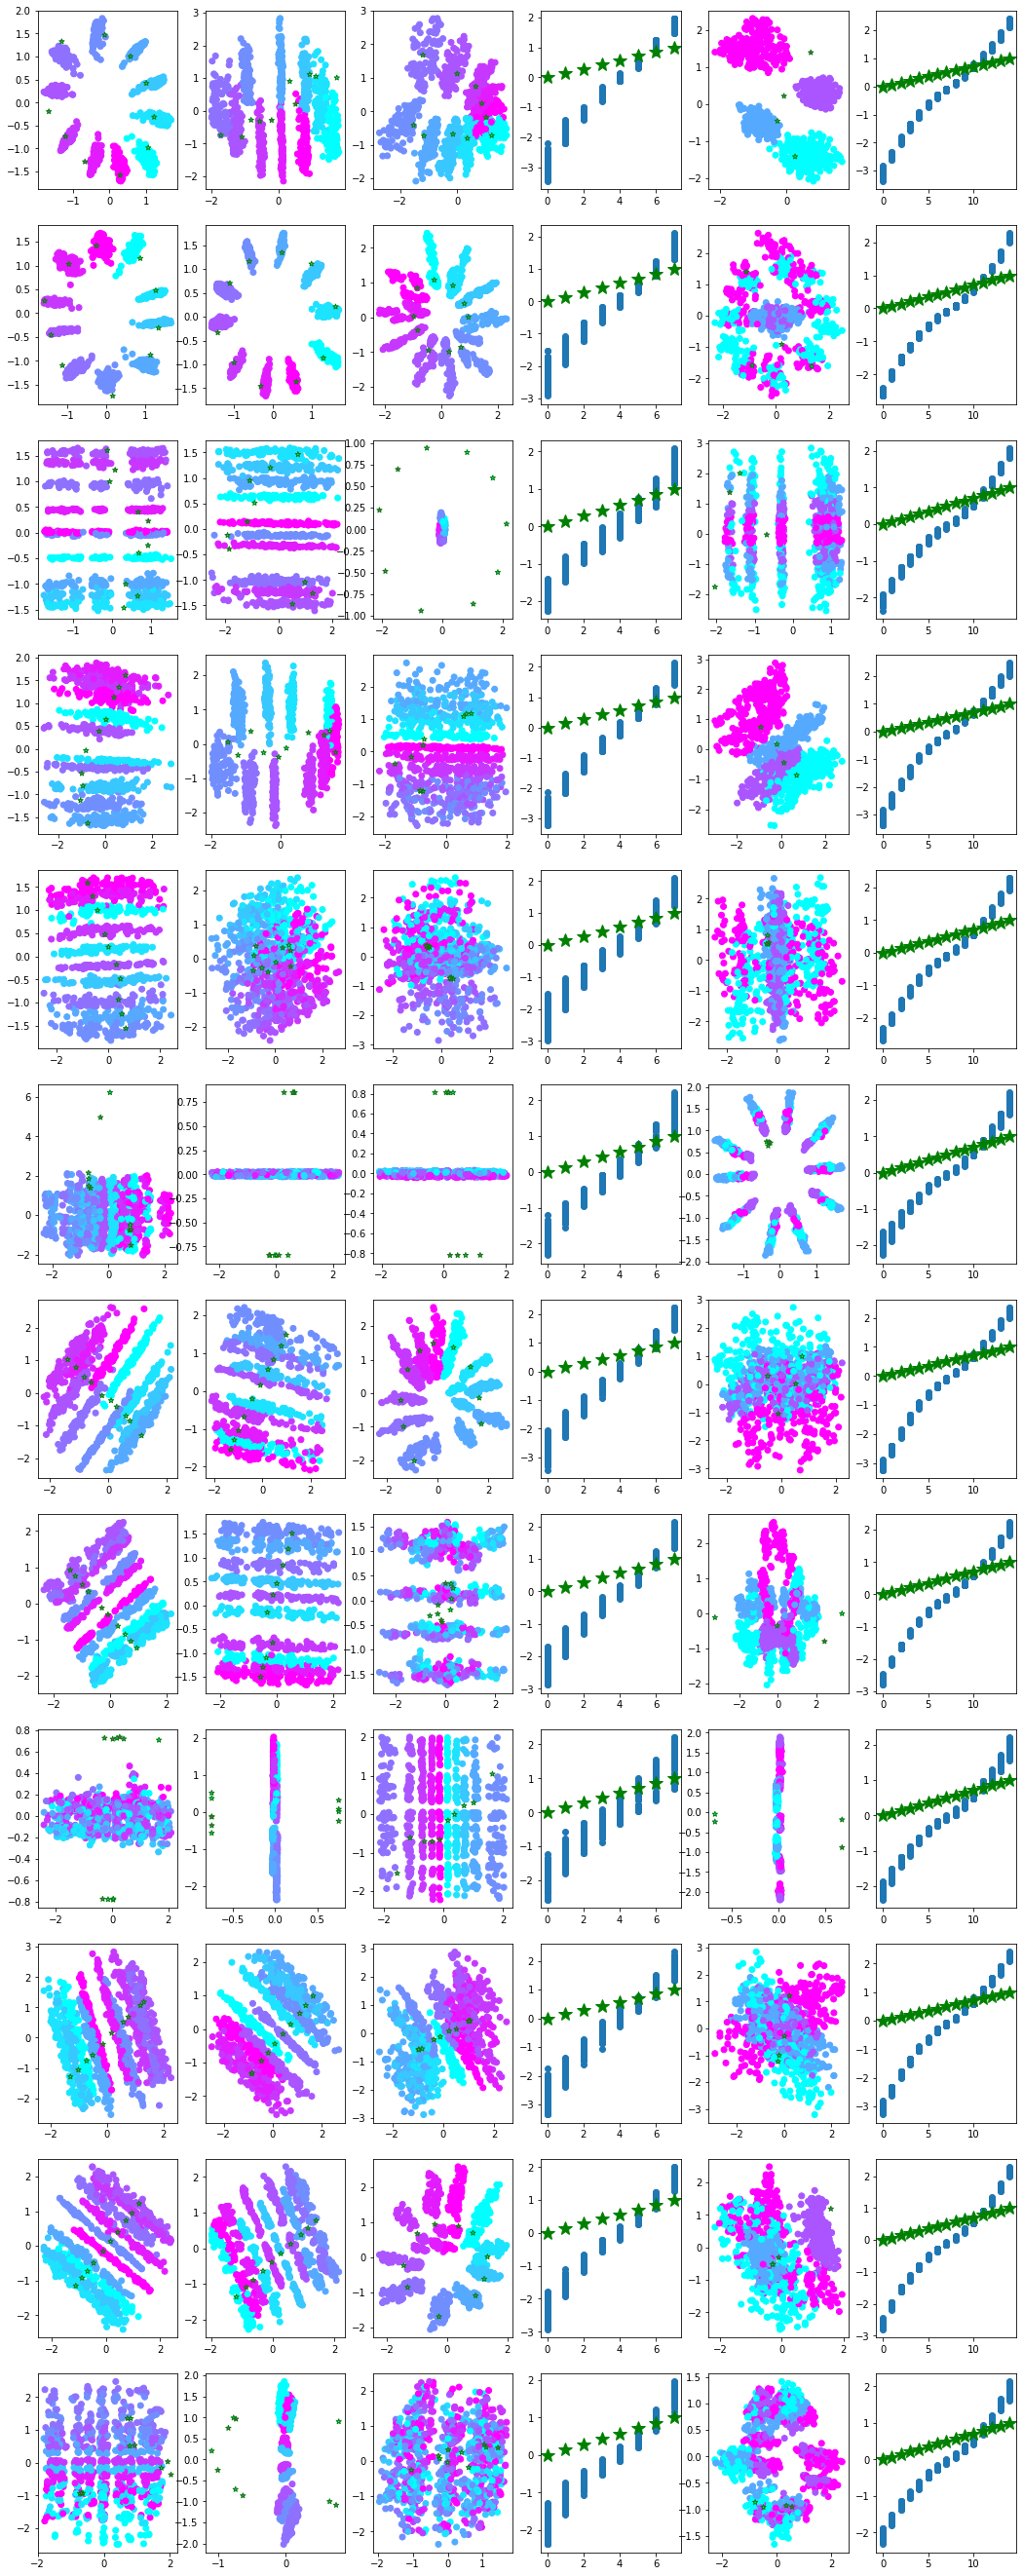

In [59]:
# works on exp v4, use model_name to find results
exp_idx = 4
dataset = shapes3d
dataset_name = 'shapes3d'
dataset_name_in_df = "'shapes3d'"
plot_random_points = True

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_embeddings_v{exp_idx}.json"
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())
print(model_indices)

fig, axs = plt.subplots(len(model_indices), num_embeddings, figsize=(18, 4*len(model_indices)))
for fig_idx, model_idx in enumerate(model_indices):
    # retrieve embeddings
    embedding = calculate_embeddings(exp_idx, model_idx, num_embeddings)
    
    # retrieve labelled points (representations and factors)
    artifact_path = f'/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/{model_idx}/model/artifacts'
    if plot_random_points:
        labelled_indices = np.random.choice(len(dataset.images), 1000, replace=False)
    else:
        labelled_indices = np.load(os.path.join(artifact_path, 'labelled_indices_iter_0.npy'))
    
    representations = np.load(os.path.join(artifact_path, 'dropout_mean_iter_1.npy'))
    labelled_factors = dataset.index_to_factors(labelled_indices)
    labelled_representations = representations[labelled_indices, :]
    
    latent_idx = 0
    learned_embedding_idx = 0
    for emb_idx in range(num_embeddings):
        ax = axs[fig_idx, emb_idx]
        if loss_terms[emb_idx] == 'multidimensional_embed':
            curr_embedding = embedding[learned_embedding_idx]
            learned_embedding_idx += 1
        else:
            curr_embedding = np.expand_dims(np.linspace(0, 1, dataset.factor_sizes[emb_idx]), axis=1)
        
        if embedding_dimensions[emb_idx] == 1:
            ax.scatter(labelled_factors[:, emb_idx], labelled_representations[:, latent_idx])
            ax.plot(list(range(len(curr_embedding))), curr_embedding[:, 0], 'g*', ms=15)
            latent_idx += 1
        else:
            colors = labelled_factors[:, emb_idx] / dataset.factor_sizes[emb_idx]
            ax.scatter(
                labelled_representations[:, latent_idx],
                labelled_representations[:, latent_idx+1],
                c = colors,
                cmap='cool'
            )
            ax.scatter(
                curr_embedding[:, 0],
                curr_embedding[:, 1],
                c = np.linspace(0, 1, dataset.factor_sizes[emb_idx]),
                marker = '*',
                edgecolors = 'g',
                s = 30,
                cmap='cool'
            )
            latent_idx += 2
            
    
    

In [58]:
exp_idx = 4
model_idx = 17
factor_idx = 0

artifact_path = f'/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/{model_idx}/model/artifacts'
sap_results = np.load(os.path.join(artifact_path, 'multidimensional_sap_results.npy'))
sorted_indices = np.argsort(sap_results[factor_idx, :])
for idx in sorted_indices[::-1]:
    print(classifier_latent_indices[idx], sap_results[factor_idx, idx])

(1, 7) 0.8924
(0, 7) 0.4986
(1, 5) 0.4948
(1, 9) 0.4678
(3, 7) 0.4604
(4, 7) 0.4556
(2, 7) 0.4524
(7,) 0.4468
(5, 7) 0.4312
(1, 8) 0.4234
(7, 9) 0.4204
(1,) 0.416
(1, 3) 0.3968
(1, 2) 0.3912
(1, 4) 0.3618
(1, 6) 0.3594
(7, 8) 0.3564
(0, 1) 0.3424
(6, 7) 0.323
(4, 8) 0.1364
(4, 9) 0.1298
(2, 4) 0.129
(0, 4) 0.1282
(4, 5) 0.1268
(4,) 0.1256
(3, 4) 0.1246
(4, 6) 0.1236
(2, 5) 0.1198
(5,) 0.1168
(5, 8) 0.1164
(5, 6) 0.1126
(5, 9) 0.1124
(0, 6) 0.1112
(2, 6) 0.111
(3, 5) 0.1108
(2, 8) 0.1096
(2, 3) 0.1068
(3, 6) 0.106
(0, 2) 0.105
(0, 3) 0.1046
(6, 9) 0.104
(2,) 0.1026
(0,) 0.1018
(0, 5) 0.1006
(8,) 0.1004
(0, 8) 0.0998
(9,) 0.0986
(0, 9) 0.0984
(8, 9) 0.097
(2, 9) 0.0964
(3, 9) 0.0962
(6,) 0.0952
(3, 8) 0.0948
(6, 8) 0.094
(3,) 0.0846


##### exp v5: all multiembed-VAE

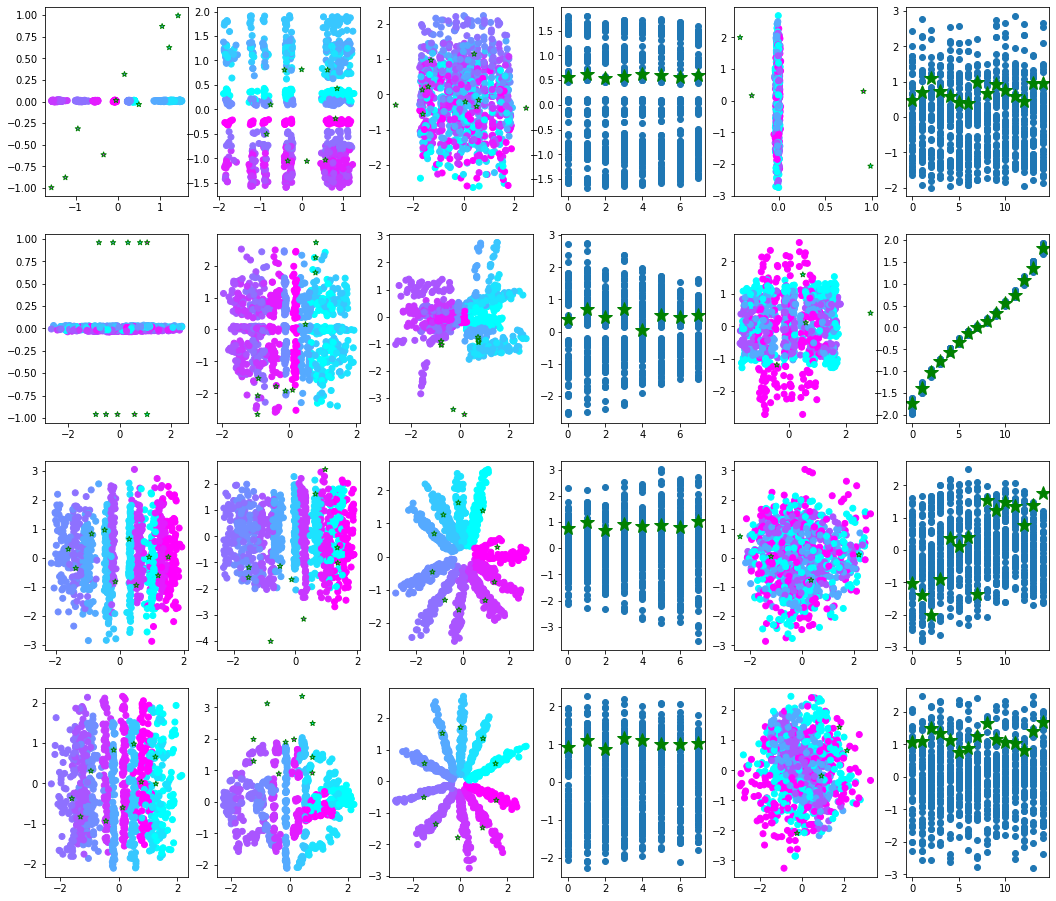

In [63]:
exp_idx = 5
dataset = shapes3d
dataset_name = 'shapes3d'
dataset_name_in_df = "'shapes3d'"
storage_path = '/mnt/data1/active_learning_representations/'

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_embeddings_v{exp_idx}.json"
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

fig, axs = plt.subplots(len(model_indices), num_embeddings, figsize=(18, 4*len(model_indices)))
for fig_idx, model_idx in enumerate(model_indices):
    # retrieve embeddings
    embedding = calculate_embeddings(exp_idx, model_idx, num_embeddings, storage_path=storage_path)
    
    # retrieve labelled points (representations and factors)
    artifact_path = f'{storage_path}output_embeddings_study_v{exp_idx}/{model_idx}/model/artifacts'
    labelled_indices = np.random.choice(len(dataset.images), 1000, replace=False)
    # labelled_indices = np.load(os.path.join(artifact_path, 'labelled_indices_iter_0.npy'))
    representations = np.load(os.path.join(artifact_path, 'dropout_mean_iter_1.npy'))
    labelled_factors = dataset.index_to_factors(labelled_indices)
    labelled_representations = representations[labelled_indices, :]
    
    latent_idx = 0
    for emb_idx in range(num_embeddings):
        ax = axs[fig_idx, emb_idx]
        assert exp_idx == 5
        curr_embedding = embedding[emb_idx]
        
        if embedding_dimensions[emb_idx] == 1:
            ax.scatter(labelled_factors[:, emb_idx], labelled_representations[:, latent_idx])
            ax.plot(list(range(len(curr_embedding))), curr_embedding[:, 0], 'g*', ms=15)
            latent_idx += 1
        else:
            colors = labelled_factors[:, emb_idx] / dataset.factor_sizes[emb_idx]
            ax.scatter(
                labelled_representations[:, latent_idx],
                labelled_representations[:, latent_idx+1],
                c = colors,
                cmap='cool'
            )
            ax.scatter(
                curr_embedding[:, 0],
                curr_embedding[:, 1],
                c = np.linspace(0, 1, dataset.factor_sizes[emb_idx]),
                marker = '*',
                edgecolors = 'g',
                s = 30,
                cmap='cool'
            )
            latent_idx += 2
            
    
    

##### exp v7: fixed VQ-VAE

In [33]:
tmp = df[[
    'train_final_config.model.model_num',
    'train_final_config.vq_vae.beta',
    'train_final_config.vq_vae.gamma_sup',
    'train_final_results.reconstruction_loss',
    'train_final_results.latent_loss',
    'train_final_results.supervised_loss',
    'train_final_results.perplexity',
]].set_index('train_final_config.model.model_num')

tmp.sort_index()

train_final_config.vq_vae.beta  \
train_final_config.model.model_num                                   
0                                                                1   
1                                                                1   
2                                                                1   
3                                                                4   
4                                                                4   
5                                                                4   
6                                                               16   
7                                                               16   
8                                                               16   
9                                                               64   
10                                                              64   
11                                                              64   
12                                                               1   
13                                                               1   
14                                                               1   
15                                                               4   
16                                                               4   
17                                                               4   
18                                                              16   
19                                                              16   
20                                                              16   
21                                                              64   
22                                                              64   
23                                                              64   

                                    train_final_config.vq_vae.gamma_sup  \
train_final_config.model.model_num                                        
0                                                                  0.25   
1                                                                  1.00   
2                                                                  4.00   
3                                                                  0.25   
4                                                                  1.00   
5                                                                  4.00   
6                                                                  0.25   
7                                                                  1.00   
8                                                                  4.00   
9                                                                  0.25   
10                                                                 1.00   
11                                                                 4.00   
12                                                                 0.25   
13                                                                 1.00   
14                                                                 4.00   
15                                                                 0.25   
16                                                                 1.00   
17                                                                 4.00   
18                                                                 0.25   
19                                                                 1.00   
20                                                                 4.00   
21                                                                 0.25   
22                                                                 1.00   
23                                                                 4.00   

                                    train_final_results.reconstruction_loss  \
train_final_config.model.model_num                                            
0                                                               3774.502930   
1                          

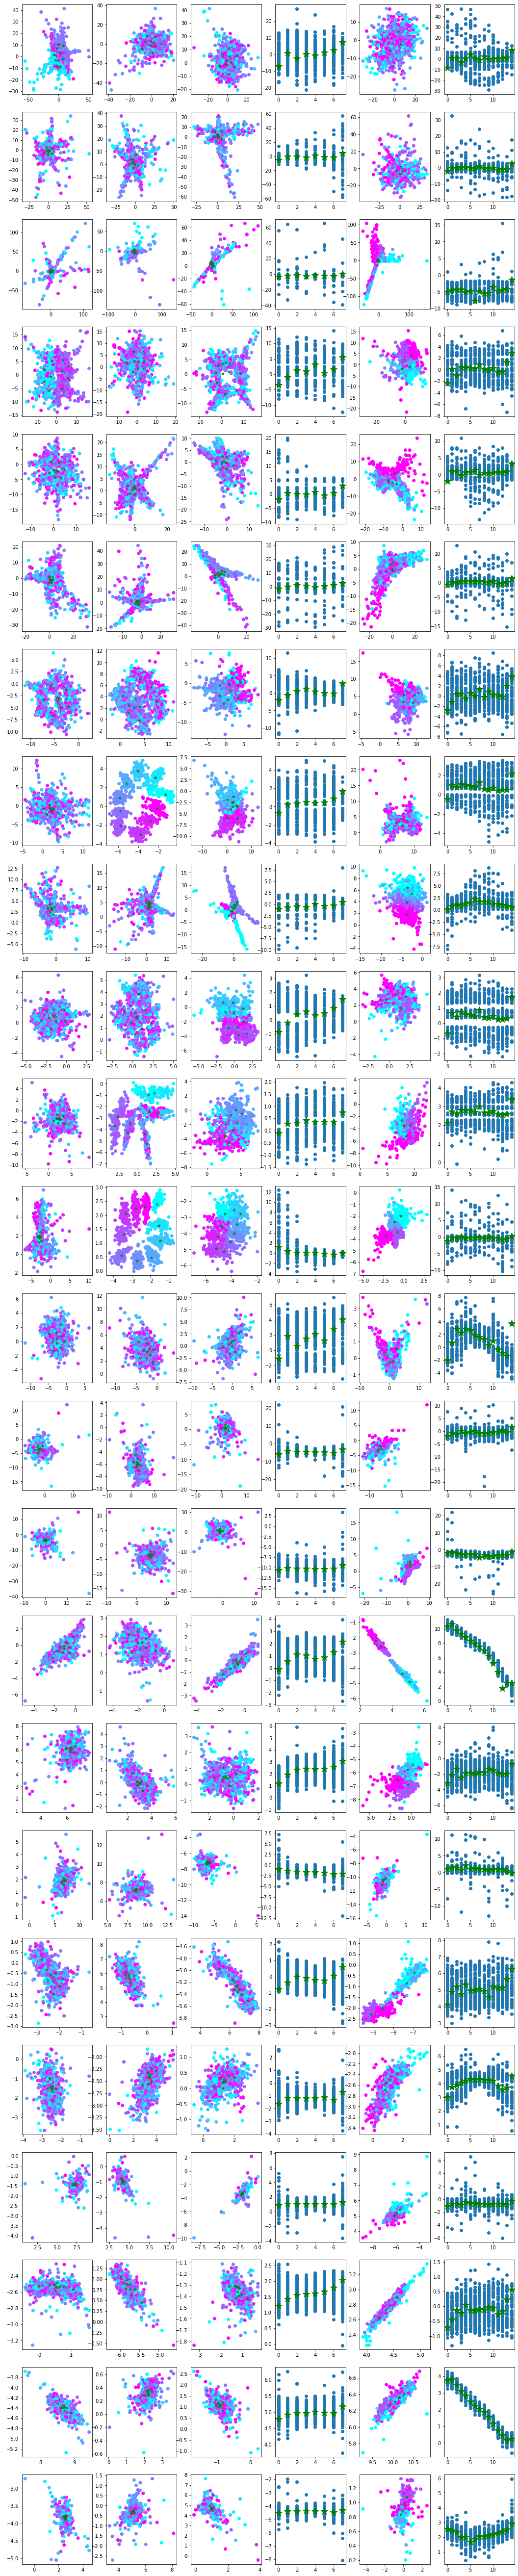

In [51]:
exp_idx = 8
dataset = shapes3d
dataset_name = 'shapes3d'
dataset_name_in_df = "'shapes3d'"
# dataset = mpi3d
# dataset_name = 'mpi3d_toy'
# dataset_name_in_df = "'mpi3d_toy'"


num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_embeddings_v{exp_idx}.json"
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())
# model_indices = [18, 21]

fig, axs = plt.subplots(len(model_indices), num_embeddings, figsize=(18, 4*len(model_indices)))
for fig_idx, model_idx in enumerate(model_indices):
    # retrieve embeddings
    embedding = calculate_embeddings(exp_idx, model_idx, num_embeddings)
    
    # retrieve labelled points (representations and factors)
    artifact_path = f'/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/{model_idx}/model/artifacts'
    labelled_indices = np.load(os.path.join(artifact_path, 'labelled_indices_iter_0.npy'))
    # labelled_indices = np.random.choice(len(dataset.images), 1000, replace=False)
    representations = np.load(os.path.join(artifact_path, 'dropout_mean_iter_1.npy'))
    labelled_factors = dataset.index_to_factors(labelled_indices)
    labelled_representations = representations[labelled_indices, :]
    
    latent_idx = 0
    for emb_idx in range(num_embeddings):
        ax = axs[fig_idx, emb_idx]
        curr_embedding = embedding[emb_idx]
        
        # TODO: only for display issues!!
        # curr_embedding *= 300
        if embedding_dimensions[emb_idx] == 1:
            ax.scatter(labelled_factors[:, emb_idx], labelled_representations[:, latent_idx])
            ax.plot(list(range(len(curr_embedding))), curr_embedding, 'g*', ms=15)
            latent_idx += 1
        else:
            colors = labelled_factors[:, emb_idx] / dataset.factor_sizes[emb_idx]
            ax.scatter(
                labelled_representations[:, latent_idx],
                labelled_representations[:, latent_idx+1],
                c = colors,
                cmap='cool'
            )
            ax.scatter(
                curr_embedding[:, 0],
                curr_embedding[:, 1],
                c = np.linspace(0, 1, dataset.factor_sizes[emb_idx]),
                marker = '*',
                edgecolors = 'g',
                s = 30,
                cmap='cool'
            )
            latent_idx += 2
            
    
    

#### compare multiD SAP score across different settings

In [64]:
def load_sap_results(exp_folder_path, model_idx):
    """Load pre-calculated SAP results"""
    sap_results_path = os.path.join(
        exp_folder_path,
        f"{model_idx}/model/artifacts/multidimensional_sap_results.npy"
    )
    return np.load(sap_results_path)

In [65]:
def calculate_sap_score_info(results):
    latent_dim_dict = {10: 1, 55: 2, 175: 3}
    max_dim = latent_dim_dict[results.shape[1]]
    sap_results = np.zeros((len(results), 3 * max_dim))
    for factor in range(len(results)):
        if max_dim >= 1:
            one_factor_results = sorted(results[factor][:10], reverse=True)
            sap_results[factor, 0] = one_factor_results[0]
            sap_results[factor, 1] = one_factor_results[1]
            sap_results[factor, 2] = one_factor_results[0] - one_factor_results[1]
        if max_dim >= 2:
            start_idx = 10
            two_unit_results = np.argsort(results[factor][start_idx:55])[::-1]
            best_pair = set(classifier_latent_indices[start_idx + two_unit_results[0]])
            sap_results[factor, 3] = results[factor][start_idx + two_unit_results[0]]
            for i in range(1, len(two_unit_results)):
                candidate_pair = set(classifier_latent_indices[start_idx + two_unit_results[i]])
                if not best_pair.intersection(set(candidate_pair)):
                    sap_results[factor, 4] = results[factor][start_idx + two_unit_results[i]]
                    break
            sap_results[factor, 5] = sap_results[factor, 3] - sap_results[factor, 4]
        if max_dim >= 3:
            start_idx = 55
            three_unit_results = np.argsort(results[factor][start_idx:175])[::-1]
            best_pair = set(classifier_latent_indices[start_idx + three_unit_results[0]])
            sap_results[factor, 6] = results[factor][start_idx + three_unit_results[0]]
            for i in range(1, len(three_unit_results)):
                candidate_pair = set(classifier_latent_indices[start_idx + three_unit_results[i]])
                if not best_pair.intersection(set(candidate_pair)):
                    sap_results[factor, 7] = results[factor][start_idx + three_unit_results[i]]
                    break
            sap_results[factor, 8] = sap_results[factor, 6] - sap_results[factor, 7]
    return sap_results

##### MPI3D dataset

In [142]:
exp_idx = 16
dataset = mpi3d
dataset_name = 'mpi3d_toy'
dataset_name_in_df = "'mpi3d_toy'"
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_semi_v{exp_idx}.json"
model_folder_path = f"/home/mwu34/disentanglement_lib/output_active_learning_study_v{exp_idx}/"

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

sap_scores_s2_mpi = np.zeros((len(model_indices), num_embeddings, 6))

for idx, model_idx in enumerate(model_indices):
    results = load_sap_results(model_folder_path, model_idx)
    sap_scores = calculate_sap_score_info(results)
    sap_scores_s2_mpi[idx, :, :] = sap_scores

In [143]:
exp_idx = 4
dataset = mpi3d
dataset_name = 'mpi3d_toy'
dataset_name_in_df = "'mpi3d_toy'"
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_embeddings_v{exp_idx}.json"
model_folder_path = f"/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/"

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

sap_scores_mixed_mpi = np.zeros((len(model_indices), num_embeddings, 6))

for idx, model_idx in enumerate(model_indices):
    results = load_sap_results(model_folder_path, model_idx)
    sap_scores = calculate_sap_score_info(results)
    sap_scores_mixed_mpi[idx, :, :] = sap_scores

In [144]:
exp_idx = 5
dataset = mpi3d
dataset_name = 'mpi3d_toy'
dataset_name_in_df = "'mpi3d_toy'"
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_embeddings_v{exp_idx}.json"
model_folder_path = f"/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/"

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

sap_scores_multiembed_mpi = np.zeros((len(model_indices), num_embeddings, 6))

for idx, model_idx in enumerate(model_indices):
    results = load_sap_results(model_folder_path, model_idx)
    sap_scores = calculate_sap_score_info(results)
    sap_scores_multiembed_mpi[idx, :, :] = sap_scores

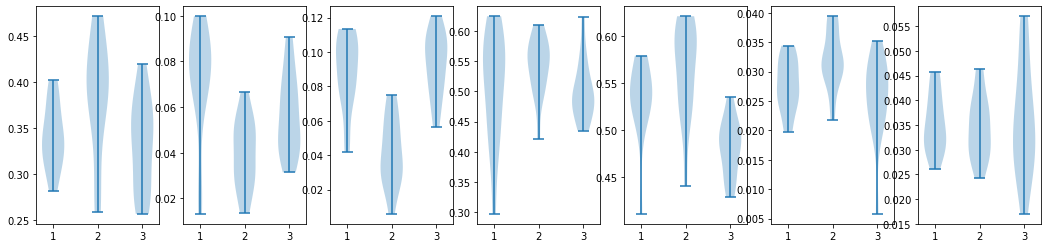

In [145]:
fig, axs = plt.subplots(1, num_embeddings, figsize=(18, 4))

for factor_idx in range(num_embeddings):
    s2_sap = np.max(sap_scores_s2_mpi[:, factor_idx, [2, 5]], 1)
    mixed_sap = np.max(sap_scores_mixed_mpi[:, factor_idx, [2, 5]], 1)
    multiembed_sap = np.max(sap_scores_multiembed_mpi[:, factor_idx, [2, 5]], 1)
    axs[factor_idx].violinplot(
        [s2_sap, mixed_sap, multiembed_sap],
        # labels=['betaS2VAE', 'mixedVAE', 'multiEmbedVAE']
    )
    
    

##### Shapes3D dataset

In [74]:
num_latents = 10
classifier_latent_indices = list(itertools.combinations(list(range(num_latents)), 1)) \
    + list(itertools.combinations(list(range(num_latents)), 2)) \
    + list(itertools.combinations(list(range(num_latents)), 3))

In [75]:
exp_idx = 17
dataset = shapes3d
dataset_name = 'shapes3d'
dataset_name_in_df = "'shapes3d'"
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_semi_v{exp_idx}.json"
model_folder_path = f"/home/mwu34/disentanglement_lib/output_active_learning_study_v{exp_idx}/"

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

sap_scores_s2_shapes = np.zeros((len(model_indices), num_embeddings, 6))

for idx, model_idx in enumerate(model_indices):
    results = load_sap_results(model_folder_path, model_idx)
    sap_scores = calculate_sap_score_info(results)
    sap_scores_s2_shapes[idx, :, :] = sap_scores

In [76]:
exp_idx = 4
dataset = shapes3d
dataset_name = 'shapes3d'
dataset_name_in_df = "'shapes3d'"
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_embeddings_v{exp_idx}.json"
model_folder_path = f"/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/"

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

sap_scores_mixed_shapes = np.zeros((len(model_indices), num_embeddings, 6))

for idx, model_idx in enumerate(model_indices):
    try:
        results = load_sap_results(model_folder_path, model_idx)
        sap_scores = calculate_sap_score_info(results)
        sap_scores_mixed_shapes[idx, :, :] = sap_scores
    except:
        print(f"can't find sap score at {model_idx}")

In [69]:
exp_idx = 5
dataset = shapes3d
dataset_name = 'shapes3d'
dataset_name_in_df = "'shapes3d'"
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_embeddings_v{exp_idx}.json"
model_folder_path = f"/mnt/data1/active_learning_representations/output_embeddings_study_v{exp_idx}/"

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

sap_scores_multiembed_shapes = np.zeros((len(model_indices), num_embeddings, 6))

for idx, model_idx in enumerate(model_indices):
    try:
        results = load_sap_results(model_folder_path, model_idx)
        sap_scores = calculate_sap_score_info(results)
        sap_scores_multiembed_shapes[idx, :, :] = sap_scores
    except:
        print(f"can't find sap score at {model_idx}")

In [71]:
exp_idx = 8
dataset = shapes3d
dataset_name = 'shapes3d'
dataset_name_in_df = "'shapes3d'"
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_embeddings_v{exp_idx}.json"
model_folder_path = f"/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/"

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

sap_scores_vq_shapes = np.zeros((len(model_indices), num_embeddings, 6))

for idx, model_idx in enumerate(model_indices):
    try:
        results = load_sap_results(model_folder_path, model_idx)
        sap_scores = calculate_sap_score_info(results)
        sap_scores_vq_shapes[idx, :, :] = sap_scores
    except:
        print(f"can't find sap score at {model_idx}")

can't find sap score at 0
can't find sap score at 1
can't find sap score at 2
can't find sap score at 3
can't find sap score at 4
can't find sap score at 5
can't find sap score at 6
can't find sap score at 7
can't find sap score at 8
can't find sap score at 9
can't find sap score at 10
can't find sap score at 11
can't find sap score at 12
can't find sap score at 13
can't find sap score at 14
can't find sap score at 15
can't find sap score at 16
can't find sap score at 17
can't find sap score at 18
can't find sap score at 19
can't find sap score at 20
can't find sap score at 21
can't find sap score at 22
can't find sap score at 23


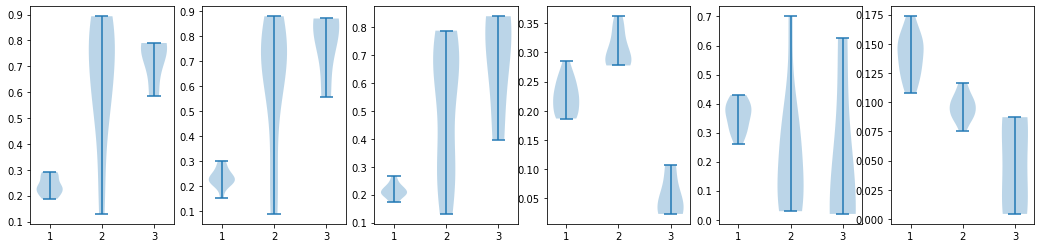

In [77]:
fig, axs = plt.subplots(1, num_embeddings, figsize=(18, 4))

for factor_idx in range(num_embeddings):
    s2_sap = np.max(sap_scores_s2_shapes[:, factor_idx, [2, 5]], 1)
    mixed_sap = np.max(sap_scores_mixed_shapes[:, factor_idx, [2, 5]], 1)
    multiembed_sap = np.max(sap_scores_multiembed_shapes[:, factor_idx, [2, 5]], 1)
    # vq_sap = np.max(sap_scores_vq_shapes[:, factor_idx, [2, 5]], 1)
    
    axs[factor_idx].violinplot(
        [s2_sap, mixed_sap, multiembed_sap],
        # labels=['betaS2VAE', 'mixedVAE', 'multiEmbedVAE']
    )
    


##### cars 3d dataset

In [173]:
exp_idx = 18
dataset = cars3d
dataset_name = 'cars3d'
dataset_name_in_df = "'cars3d'"
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_semi_v{exp_idx}.json"
model_folder_path = f"/mnt/data1/active_learning_representations/output_active_learning_study_v{exp_idx}/"

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

sap_scores_s2_cars = np.zeros((len(model_indices), num_embeddings, 9))

for idx, model_idx in enumerate(model_indices):
    results = load_sap_results(model_folder_path, model_idx)
    sap_scores = calculate_sap_score_info(results)
    sap_scores_s2_cars[idx, :, :] = sap_scores

In [175]:
exp_idx = 4
dataset = cars3d
dataset_name = 'cars3d'
dataset_name_in_df = "'cars3d'"
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_embeddings_v{exp_idx}.json"
model_folder_path = f"/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/"

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

sap_scores_mixed_cars = np.zeros((len(model_indices), num_embeddings, 9))

for idx, model_idx in enumerate(model_indices):
    results = load_sap_results(model_folder_path, model_idx)
    sap_scores = calculate_sap_score_info(results)
    sap_scores_mixed_cars[idx, :, :] = sap_scores

In [176]:
exp_idx = 5
dataset = cars3d
dataset_name = 'cars3d'
dataset_name_in_df = "'cars3d'"
aggregated_results_path = f"/home/mwu34/disentanglement_lib/results_embeddings_v{exp_idx}.json"
model_folder_path = f"/home/mwu34/disentanglement_lib/output_embeddings_study_v{exp_idx}/"

num_embeddings = dataset.num_factors
embedding_dimensions = dataset_embedding_dimensions[dataset_name]
loss_terms = dataset_supervised_loss[dataset_name]
df = pd.read_json(aggregated_results_path)
df = df[df['train_final_config.dataset.name'] == dataset_name_in_df]
model_indices = sorted(df['train_final_config.model.model_num'].to_list())

sap_scores_multiembed_cars = np.zeros((len(model_indices), num_embeddings, 9))

for idx, model_idx in enumerate(model_indices):
    results = load_sap_results(model_folder_path, model_idx)
    sap_scores = calculate_sap_score_info(results)
    sap_scores_multiembed_cars[idx, :, :] = sap_scores

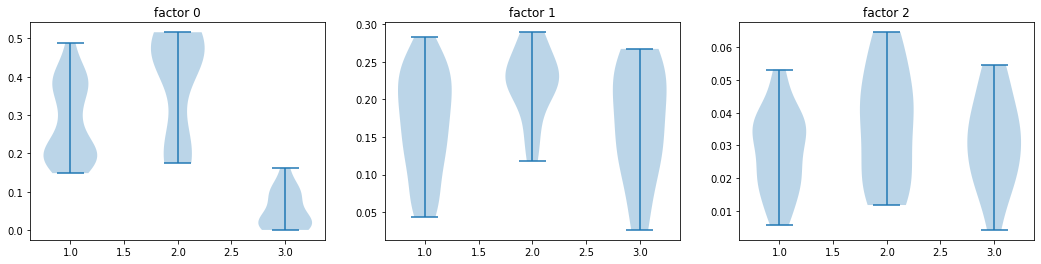

In [186]:
fig, axs = plt.subplots(1, num_embeddings, figsize=(18, 4))

factor_dict = {
    0: [2],
    1: [2, 5],
    2: [2, 5, 8],
}
for factor_idx in range(num_embeddings):
    s2_sap = np.max(sap_scores_s2_cars[:, factor_idx, factor_dict[factor_idx]], 1)
    mixed_sap = np.max(sap_scores_mixed_cars[:, factor_idx, factor_dict[factor_idx]], 1)
    multiembed_sap = np.max(sap_scores_multiembed_cars[:, factor_idx, factor_dict[factor_idx]], 1)
    
    axs[factor_idx].violinplot(
        [s2_sap, mixed_sap, multiembed_sap],
        # labels=['betaS2VAE', 'mixedVAE', 'multiEmbedVAE']
    )
    axs[factor_idx].set_title(f"factor {factor_idx}")